In [59]:
import pandas as pd

df = pd.read_csv(r"C:\Users\yigit\Downloads\USD_TRY Historical Data.csv")  

df.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,05/07/2025,38.6341,38.6186,38.6472,38.5950,NaN,-0.01%
1,05/06/2025,38.6377,38.6186,38.8255,38.3683,NaN,0.17%
2,05/05/2025,38.5720,38.5694,38.7154,38.4065,NaN,0.01%
3,05/02/2025,38.5698,38.4480,38.7148,38.3291,NaN,0.32%
4,05/01/2025,38.4479,38.4908,38.6308,38.3549,NaN,-0.11%


In [60]:

df.columns = [col.strip() for col in df.columns]

df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")  # US format

df = df.sort_values("Date")
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

df.drop(columns=['Vol.', 'Change %'], inplace=True, errors='ignore')

df.set_index("Date", inplace=True)

df.head()


,Price,Open,High,Low
Date,,,,
2015-05-07,2.6842,2.6922,2.7158,2.6768
2015-05-08,2.6932,2.6852,2.7039,2.6739
2015-05-11,2.6928,2.6890,2.7063,2.6784
2015-05-12,2.6625,2.6950,2.7065,2.6588
2015-05-13,2.6297,2.6634,2.6735,2.6211


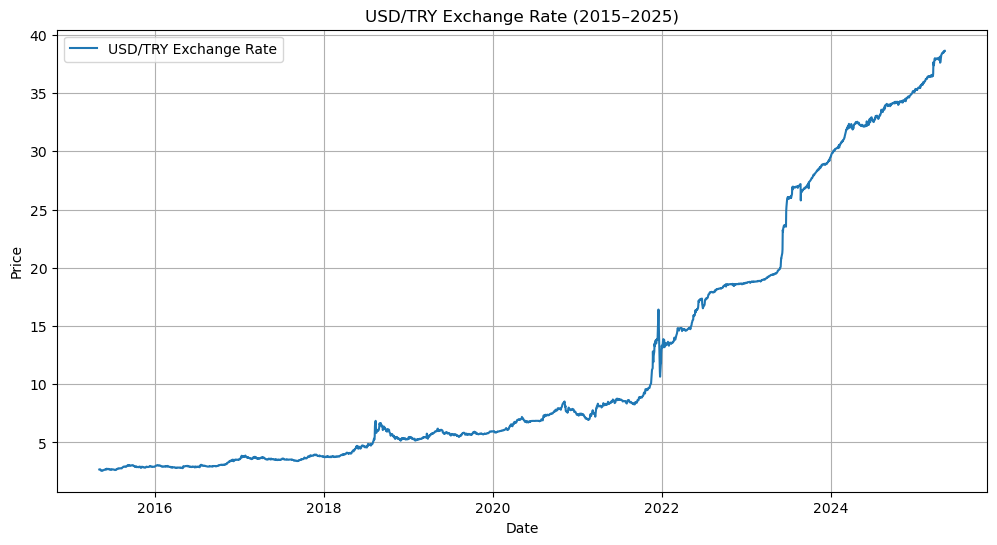

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Price'], label='USD/TRY Exchange Rate')
plt.title('USD/TRY Exchange Rate (2015–2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


In [62]:
df.describe()

,Price,Open,High,Low
count,2610.000000,2610.000000,2610.000000,2610.000000
mean,12.093712,12.090325,12.190743,12.012851
std,10.807561,10.808387,10.880675,10.753619
min,2.574900,2.576700,2.591000,2.559500
25%,3.773250,3.773575,3.799025,3.754525
50%,6.816500,6.815500,6.854700,6.791750
75%,18.588175,18.597500,18.706375,18.482075
max,38.637700,38.618600,41.216400,38.595000


<Axes: title={'center': 'Daily Return (%)'}, xlabel='Date'>

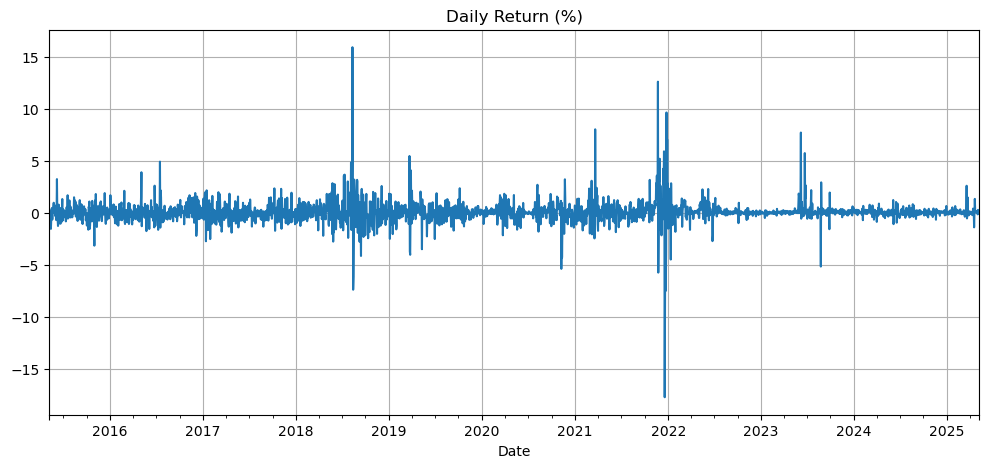

In [63]:
df['Return'] = df['Price'].pct_change() * 100  
df['Return'].plot(figsize=(12, 5), title='Daily Return (%)', grid=True)


<Axes: title={'center': 'Rolling Volatility (30-day)'}, xlabel='Date'>

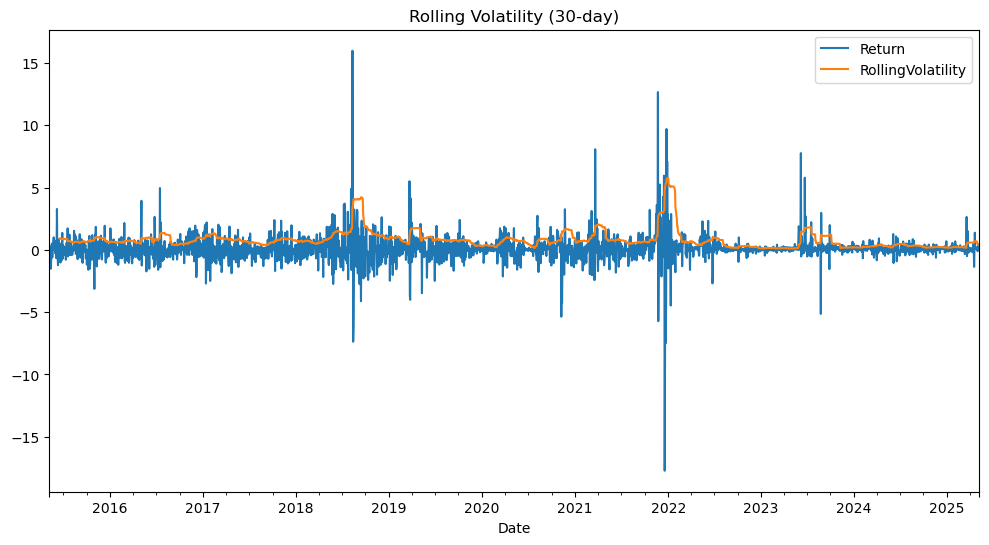

In [64]:
df['RollingVolatility'] = df['Return'].rolling(window=30).std()

df[['Return', 'RollingVolatility']].plot(figsize=(12,6), title='Rolling Volatility (30-day)')


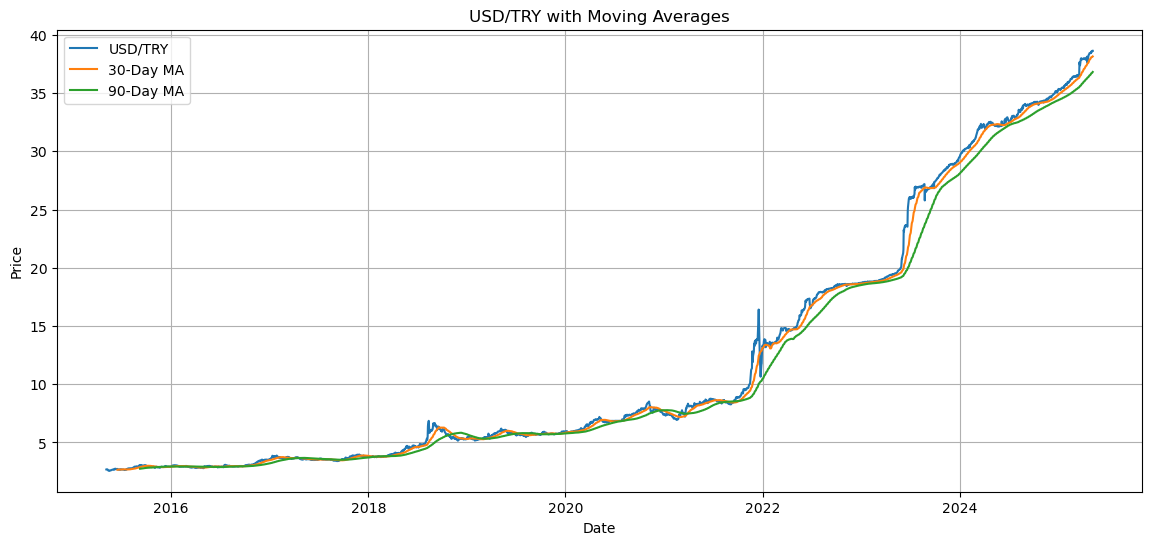

In [65]:

df['MA30'] = df['Price'].rolling(window=30).mean()
df['MA90'] = df['Price'].rolling(window=90).mean()


plt.figure(figsize=(14,6))
plt.plot(df['Price'], label='USD/TRY')
plt.plot(df['MA30'], label='30-Day MA')
plt.plot(df['MA90'], label='90-Day MA')
plt.title('USD/TRY with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


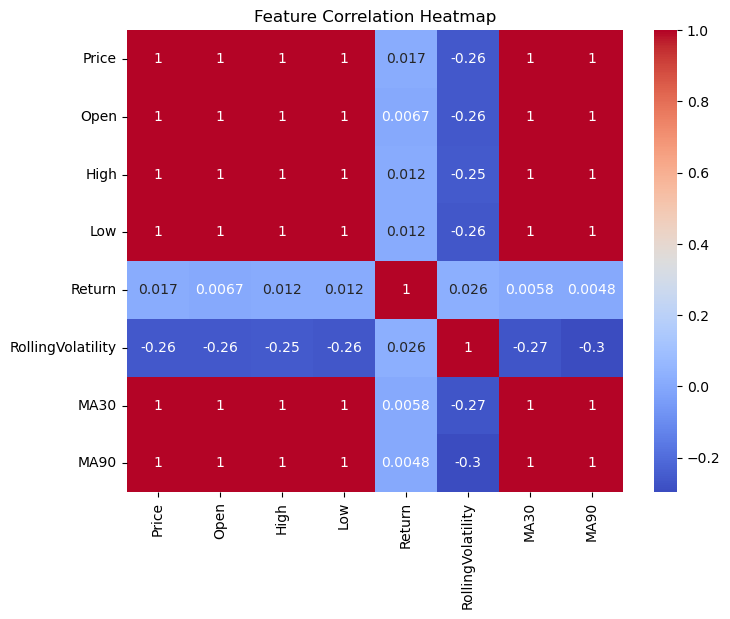

In [66]:

eda_df = df.dropna()
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(eda_df[['Price', 'Open', 'High', 'Low', 'Return', 'RollingVolatility', 'MA30', 'MA90']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [67]:
eda_df.to_csv("usd_try_eda_ready.csv")


In [68]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [69]:
features = ['Price', 'Return', 'RollingVolatility', 'MA30', 'MA90']


In [70]:
data = eda_df[features].copy()


In [71]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)
scaled_df.head()


,Price,Return,RollingVolatility,MA30,MA90
Date,,,,,
2015-09-09,0.006710,0.550453,0.087965,0.001255,0.000000
2015-09-10,0.006297,0.511430,0.090473,0.001480,0.000110
2015-09-11,0.007003,0.550764,0.089437,0.001740,0.000224
2015-09-14,0.007318,0.536915,0.089438,0.002001,0.000343
2015-09-15,0.006542,0.498912,0.096238,0.002235,0.000463


In [72]:
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  
        y.append(data[i][0])             
    return np.array(X), np.array(y)


In [73]:
window_size = 60  
X, y = create_sequences(scaled_data, window_size)
print(f'Shape of X: {X.shape}, Shape of y: {y.shape}')


Shape of X: (2461, 60, 5), Shape of y: (2461,)


In [74]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')


Train shape: (1968, 60, 5), Test shape: (493, 60, 5)


In [75]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [76]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [77]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [78]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, num_layers=3 , dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step's output
        out = self.fc(out)
        return out


In [79]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [80]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        output = model(batch_X).squeeze()
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/20, Loss: 0.0115
Epoch 2/20, Loss: 0.0002
Epoch 3/20, Loss: 0.0002
Epoch 4/20, Loss: 0.0002
Epoch 5/20, Loss: 0.0002
Epoch 6/20, Loss: 0.0001
Epoch 7/20, Loss: 0.0002
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0002
Epoch 10/20, Loss: 0.0001
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0001
Epoch 13/20, Loss: 0.0002
Epoch 14/20, Loss: 0.0001
Epoch 15/20, Loss: 0.0001
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0001
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0001


In [81]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).squeeze().numpy()


In [82]:

from sklearn.preprocessing import MinMaxScaler

price_scaler = MinMaxScaler()
price_scaler.fit(eda_df[['Price']])

y_pred = price_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = price_scaler.inverse_transform(y_test.reshape(-1, 1))


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")


RMSE: 2.4508, MAE: 2.2221


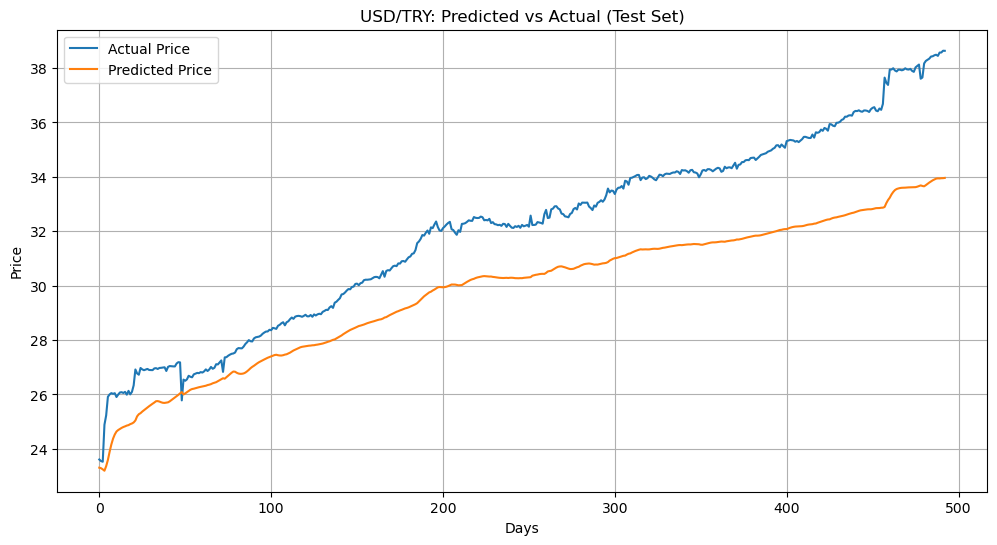

In [84]:

plt.figure(figsize=(12, 6))
plt.plot(y_true, label="Actual Price")
plt.plot(y_pred, label="Predicted Price")
plt.title("USD/TRY: Predicted vs Actual (Test Set)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [112]:
torch.save(model.state_dict(), "currency_lstm_model.pth")
